## Retraining 'eye_tracking' model for subject and predicting eye track (pixel coordinate).

In [32]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import numpy as np
import pickle
from sklearn.utils import shuffle
from joblib import load as jload
from joblib import dump as jdump
import time
import os
# import tuning_parameters as tp

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
# Parameters
PATH2PROJECT = "/content/drive/MyDrive/Projects/EyeTracker/"
target_folder = "subjects/"

# et_public_scaler_dir = PATH2PROJECT + f"models/eye_tracking/trained/scalers{tp.EYE_TRACKING_MODEL_NUMBER}.bin"
# et_public_model_dir = PATH2PROJECT + f"models/eye_tracking/trained/model{tp.EYE_TRACKING_MODEL_NUMBER}"

EYE_TRACKING_MODEL_NUMBER = 3
et_public_scaler_dir = PATH2PROJECT + f"models/eye_tracking/trained/scalers{EYE_TRACKING_MODEL_NUMBER}.bin"
et_public_model_dir = PATH2PROJECT + f"models/eye_tracking/trained/model{EYE_TRACKING_MODEL_NUMBER}"
SUBJECT_NUM = 2
CHOSEN_INPUTS = [0, 1, 2, 6, 7, 8, 9]

R_TRAIN = 0.85
N_EPOCHS = 100
PATIENCE = 10
TRAINABLE_LAYERS = 1

In [35]:
# subject_dir = PATH2PROJECT + target_folder + f"/{tp.NUMBER}/"
subject_dir = PATH2PROJECT + target_folder + f"{SUBJECT_NUM}/"
ibo_subject_scaler_dir = subject_dir + "scalers_in_blink_out.bin"
ibo_subject_model_dir = subject_dir + "model_in_blink_out"

### Retraining 'eye_tracking' model with subject calibration data

In [36]:
et_clb_fol = subject_dir + "eye_tracking data-calibration/"
print(f"\nLoading subject data in {et_clb_fol}")
with open(et_clb_fol + "x1.pickle", "rb") as f:
    x1_load = pickle.load(f)
with open(et_clb_fol + "x2.pickle", "rb") as f:
    x2_load = pickle.load(f)
with open(et_clb_fol + "y.pickle", "rb") as f:
    y_load = pickle.load(f)
n_smp, frame_height, frame_width = x1_load.shape[:-1]
print(f"Samples number: {n_smp}")
time.sleep(2)


Loading subject data in /content/drive/MyDrive/Projects/EyeTracker/subjects/2/eye_tracking data-calibration/
Samples number: 7000


In [37]:
import matplotlib.pyplot as plt

[-2.77370058e+00 -7.44353733e-02 -2.00434757e-02  3.10411937e+00
  3.51741753e+00  6.38527849e+01  4.75242794e-01  4.60822523e-01
  4.91144359e-01  4.77497756e-01]
[1844  508]


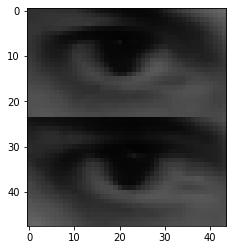

In [38]:
# Displaying data
SAMPLE_NUMBER = 50
print(x2_load[SAMPLE_NUMBER])
print(y_load[SAMPLE_NUMBER])
plt.imshow(x1_load[SAMPLE_NUMBER].reshape((frame_height, frame_width)),
           cmap="gray", vmin=0, vmax=255)
plt.show()

#### Getting those data that looking 'in' screen

In [39]:
print("\nNormalizing data...")
# x2_chs_inp = x2_load[:, tp.CHOSEN_INPUTS]
x2_chs_inp = x2_load[:, CHOSEN_INPUTS]
scalers_ibo = jload(ibo_subject_scaler_dir)
x1_scaler_ibo, x2_scaler_ibo = scalers_ibo
x1 = x1_load / x1_scaler_ibo
x2 = x2_scaler_ibo.transform(x2_chs_inp)
time.sleep(2)


Normalizing data...


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [40]:
print("\nLoading in_blink_out model...")
model_ibo = load_model(ibo_subject_model_dir)
print(model_ibo.summary())
time.sleep(2)


Loading in_blink_out model...
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 44, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 48, 44, 16)   416         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 24, 22, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 24, 22, 32)   12832       max_pooling2d[0][0]              
_______________________________________________________________

In [41]:
print("\nPredicting those data that looking 'in' screen.")
x = [x1, x2]
yhat_ibo = model_ibo.predict(x).argmax(1)
time.sleep(2)


Predicting those data that looking 'in' screen.


In [42]:
# Choosing those data
x1_new = []
x2_new = []
y_new = []
for (x10, x20, y0, yht0) in zip(x1_load, x2_load, y_load, yhat_ibo):
    if True: # yht0 != 1:
        x1_new.append(x10)
        x2_new.append(x20)
        y_new.append(y0)

x1_new = np.array(x1_new)
x2_new = np.array(x2_new)
y_new = np.array(y_new)
n_smp_new = x1_new.shape[0]
print(f"New samples: {n_smp_new}")

New samples: 7000


### Preparing modified calibration data to feeding in eye_tracking model

In [43]:
print("\nNormalizing modified calibration data to feeding in eye_tracking model...")
# x2_chs_inp_new = x2_new[:, tp.CHOSEN_INPUTS]
x2_chs_inp_new = x2_new[:, CHOSEN_INPUTS]
scalers_et = jload(et_public_scaler_dir)
x1_scaler_et, x2_scaler_et, _ = scalers_et

x1_nrm = x1_new / x1_scaler_et
x2_nrm = x2_scaler_et.transform(x2_chs_inp_new)

y_scalers_et = y_new.max(0)
y_nrm = y_new / y_scalers_et

scalers_et[2] = y_scalers_et
jdump(scalers_et, subject_dir + "scalers_eye_tracking.bin")


Normalizing modified calibration data to feeding in eye_tracking model...


['/content/drive/MyDrive/Projects/EyeTracker/subjects/2/scalers_eye_tracking.bin']

In [44]:
# Shuffling and splitting data to train and test
x1_shf, x2_shf, yx_shf, yy_shf = shuffle(x1_nrm, x2_nrm, y_nrm[:, 0], y_nrm[:, 1])

n_train = int(R_TRAIN * n_smp_new)
n_test = n_smp_new - n_train
x1_train, x2_train = x1_shf[:n_train], x2_shf[:n_train]
x1_test, x2_test = x1_shf[n_train:], x2_shf[n_train:]
yx_train, yy_train = yx_shf[:n_train], yy_shf[:n_train]
yx_test, yy_test = yx_shf[n_train:], yy_shf[n_train:]

x_train = [x1_train, x2_train]
x_test = [x1_test, x2_test]

print(x1_train.shape, x1_test.shape, yx_train.shape, yx_test.shape,
      x2_train.shape, x2_test.shape, yy_train.shape, yy_test.shape)

(5950, 48, 44, 1) (1050, 48, 44, 1) (5950,) (1050,) (5950, 7) (1050, 7) (5950,) (1050,)


In [45]:
# Callback for training
cb = EarlyStopping(patience=PATIENCE, verbose=1, restore_best_weights=True)

In [46]:
print("Loading public eye_tracking models...")
model_x = load_model(et_public_model_dir + "_x")
model_y = load_model(et_public_model_dir + "_y")
# print(model1.summary())
time.sleep(2)

Loading public eye_tracking models...


In [47]:
for (layer1, layer2) in zip(model_x.layers[:-TRAINABLE_LAYERS], model_y.layers[:-TRAINABLE_LAYERS]):
    layer1.trainable = False
    layer2.trainable = False

print(model_x.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 44, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 48, 44, 16)   416         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 24, 22, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 24, 22, 32)   12832       max_pooling2d[0][0]              
______________________________________________________________________________________________

In [48]:
print("\nStart of training for model 1 (x-pixels)")
results_x = model_x.fit(x_train,
                        yx_train,
                        validation_data=(x_test, yx_test),
                        epochs=N_EPOCHS,
                        callbacks=cb)
time.sleep(2)
print("End of training")


Start of training for model 1 (x-pixels)
Epoch 1/100
186/186 [==============================] - 3s 11ms/step - loss: 0.0370 - val_loss: 0.0327
Epoch 2/100
186/186 [==============================] - 2s 9ms/step - loss: 0.0279 - val_loss: 0.0342
Epoch 3/100
186/186 [==============================] - 2s 9ms/step - loss: 0.0252 - val_loss: 0.0279
Epoch 4/100
186/186 [==============================] - 2s 8ms/step - loss: 0.0219 - val_loss: 0.0293
Epoch 5/100
186/186 [==============================] - 2s 9ms/step - loss: 0.0217 - val_loss: 0.0254
Epoch 6/100
186/186 [==============================] - 2s 8ms/step - loss: 0.0215 - val_loss: 0.0276
Epoch 7/100
186/186 [==============================] - 2s 8ms/step - loss: 0.0199 - val_loss: 0.0257
Epoch 8/100
186/186 [==============================] - 2s 8ms/step - loss: 0.0200 - val_loss: 0.0260
Epoch 9/100
186/186 [==============================] - 2s 9ms/step - loss: 0.0189 - val_loss: 0.0236
Epoch 10/100
186/186 [==========================

In [49]:
print("\nStart of training for model 2 (y-pixels)")
results_y = model_y.fit(x_train,
                        yy_train,
                        validation_data=(x_test, yy_test),
                        epochs=N_EPOCHS,
                        callbacks=cb)
time.sleep(2)
print("End of training")


Start of training for model 2 (y-pixels)
Epoch 1/100
186/186 [==============================] - 2s 10ms/step - loss: 0.0885 - val_loss: 0.0698
Epoch 2/100
186/186 [==============================] - 2s 9ms/step - loss: 0.0621 - val_loss: 0.0574
Epoch 3/100
186/186 [==============================] - 2s 9ms/step - loss: 0.0553 - val_loss: 0.0715
Epoch 4/100
186/186 [==============================] - 2s 9ms/step - loss: 0.0526 - val_loss: 0.0526
Epoch 5/100
186/186 [==============================] - 2s 9ms/step - loss: 0.0472 - val_loss: 0.0540
Epoch 6/100
186/186 [==============================] - 2s 9ms/step - loss: 0.0468 - val_loss: 0.0481
Epoch 7/100
186/186 [==============================] - 2s 8ms/step - loss: 0.0407 - val_loss: 0.0442
Epoch 8/100
186/186 [==============================] - 2s 8ms/step - loss: 0.0391 - val_loss: 0.0549
Epoch 9/100
186/186 [==============================] - 2s 9ms/step - loss: 0.0409 - val_loss: 0.0424
Epoch 10/100
186/186 [==========================

In [50]:
print("\nSaving models...")
model_x.save(subject_dir + "model_eye_tracking_x")
model_y.save(subject_dir + "model_eye_tracking_y")
time.sleep(2)


Saving models...
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Projects/EyeTracker/subjects/2/model_eye_tracking_x/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Projects/EyeTracker/subjects/2/model_eye_tracking_y/assets


In [51]:
# Predicting outputs for train and test data
yx_hat_train = model_x.predict(x_train).reshape((n_train,))
yx_hat_test = model_x.predict(x_test).reshape((n_test,))
yy_hat_train = model_y.predict(x_train).reshape((n_train,))
yy_hat_test = model_y.predict(x_test).reshape((n_test,))

yx_hat_train[yx_hat_train < 0] = 0
yx_hat_test[yx_hat_test < 0] = 0
yy_hat_train[yy_hat_train < 0] = 0
yy_hat_test[yy_hat_test < 0] = 0

Train
(3668, 507)
(3632, 507)
Test
(1843, 507)
(2008, 525)


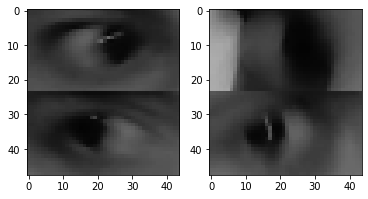

In [52]:
# Displaying data
NUM = 2
print("Train")
sample_train = (int(yx_train[NUM] * y_scalers_et[0]),
                int(yy_train[NUM] * y_scalers_et[1]))
sample_hat_train = (int(yx_hat_train[NUM] * y_scalers_et[0]),
                    int(yy_hat_train[NUM] * y_scalers_et[1]))
print(sample_train)
print(sample_hat_train)

print("Test")
sample_test = (int(yx_test[NUM] * y_scalers_et[0]),
                int(yy_test[NUM] * y_scalers_et[1]))
sample_hat_test = (int(yx_hat_test[NUM] * y_scalers_et[0]),
                    int(yy_hat_test[NUM] * y_scalers_et[1]))
print(sample_test)
print(sample_hat_test)

_, ax = plt.subplots(1,2)
ax[0].imshow((x1_train[NUM] * x1_scaler_et).astype(np.uint8).
           reshape((frame_height, frame_width)), cmap="gray",vmin=0, vmax=255)
ax[1].imshow((x1_test[NUM] * x1_scaler_et).astype(np.uint8).
           reshape((frame_height, frame_width)), cmap="gray",vmin=0, vmax=255)

### Getting sampling data that looking 'in' screen

In [53]:
eye_tracking_smp_dir = subject_dir + "sampling data/"
print(f"\nLoading subject sampling data in {eye_tracking_smp_dir}")
with open(eye_tracking_smp_dir + "t.pickle", "rb") as f:
    t_smp_load = pickle.load(f)
with open(eye_tracking_smp_dir + "x1.pickle", "rb") as f:
    x1_smp_load = pickle.load(f)
with open(eye_tracking_smp_dir + "x2.pickle", "rb") as f:
    x2_smp_load = pickle.load(f)

n_sampling= t_smp_load.shape[0]
print(f"Number of sampling data : {n_sampling}")


Loading subject sampling data in /content/drive/MyDrive/Projects/EyeTracker/subjects/2/sampling data/
Number of sampling data : 604


In [54]:
# Normalizing Sampling data for 'in_blink_out' model
# x2_smp_chs_inp = x2_smp_load[:, tp.CHOSEN_INPUTS]
x2_smp_chs_inp = x2_smp_load[:, CHOSEN_INPUTS]
x1_smp = x1_smp_load / x1_scaler_ibo
x2_smp = x2_scaler_ibo.transform(x2_smp_chs_inp)
x_smp = [x1_smp, x2_smp]

In [55]:
print("\nPredicting those data that looking 'in' screen...")
yhat_smp_ibo = model_ibo.predict(x_smp).argmax(1)


Predicting those data that looking 'in' screen...


In [56]:
# Choosing those data
t_smp_new = []
x1_smp_new = []
x2_smp_new = []
for (t0, x10, x20, yht0) in zip(t_smp_load, x1_smp_load, x2_smp_load, yhat_smp_ibo):
    if True: # yht0 == 0:
        t_smp_new.append(t0)
        x1_smp_new.append(x10)
        x2_smp_new.append(x20)

t_smp_new = np.array(t_smp_new)
x1_smp_new = np.array(x1_smp_new)
x2_smp_new = np.array(x2_smp_new)
n_sampling_new = x1_smp_new.shape[0]
print(f"New samples: {n_sampling_new}")

New samples: 604


### Predicting eye track for samling data in pixels.

In [57]:
# Normalizing Sampling data for 'eye_tracking' model
# x2_smp_new_chs_inp = x2_smp_new[:, tp.CHOSEN_INPUTS]
x2_smp_new_chs_inp = x2_smp_new[:, CHOSEN_INPUTS]
x1_smp_nrm = x1_smp_new / x1_scaler_et
x2_smp_nrm = x2_scaler_et.transform(x2_smp_new_chs_inp)
x_smp = [x1_smp_nrm, x2_smp_nrm]

In [58]:
print("\nPredicting sampling data...")
yx_hat_smp = np.expand_dims(model_x.predict(x_smp).reshape((n_sampling_new,)), 1)
yy_hat_smp = np.expand_dims(model_y.predict(x_smp).reshape((n_sampling_new,)), 1)

pixels = (np.concatenate([yx_hat_smp, yy_hat_smp], 1) * y_scalers_et).astype(np.uint32)


Predicting sampling data...


In [59]:
eye_tracking_pixels_dir = subject_dir + "sampling data-pixels/"
if not os.path.exists(eye_tracking_pixels_dir):
    os.mkdir(eye_tracking_pixels_dir)

with open(eye_tracking_pixels_dir + "t.pickle", 'wb') as f:
    pickle.dump(t_smp_new, f)
with open(eye_tracking_pixels_dir + "pixels.pickle", 'wb') as f:
    pickle.dump(pixels, f)
print("\nPixel data saved!!")


Pixel data saved!!
